<a href="https://colab.research.google.com/github/vv910511/2022AI_Final_project/blob/main/AI_NumberPlate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -r drive/MyDrive/yolov7/requirements.txt
!pip install -r drive/MyDrive/yolov7/requirements_gpu.txt

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.0 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.6/1.6 GB 124.5 MB/s eta 0:00:01tcmalloc: large alloc 1636999168 bytes == 0x301c000 @  0x7f41a6eba1e7 0x4d30a0 0x4d312c 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4997a2
tcmalloc: large alloc 2046255104 bytes == 0x64946000 @  0x7f41a6ebb615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x49

In [ ]:
%cd drive/MyDrive/yolov7/
!python train.py --workers 1 --device 0 --batch-size 16 --epochs 100 --img 640 640 --hyp data/hyp.scratch.custom.yaml --name yolov7-custom --weights yolov7.pt

[Errno 2] No such file or directory: 'drive/MyDrive/yolov7/'
/content/drive/MyDrive/yolov7
YOLOR 🚀 2022-12-25 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='data/coco.yaml', device='0', entity=None, epochs=100, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.custom.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov7-custom', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov7-custom7', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, v5_metric=False, weights='yolov7.pt', workers=1, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, mome

In [ ]:
!python detect.py --weights best.pt --conf 0.5 --img-size 640 --source 16.jpg --view-img --no-trace

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=True, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='16.jpg', update=False, view_img=True, weights=['best.pt'])
YOLOR 🚀 2022-12-25 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
/usr/local/lib/python3.8/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 306 layers, 36479926 parameters, 6194944 gradients, 103.2 GFLOPS
Done. (20.4ms) Inference, (0.3ms) NMS
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr

In [ ]:
import os
path='/content/drive/MyDrive/yolov7'
os.chdir(path)
print(os.getcwd())

/content/drive/MyDrive/yolov7


In [ ]:
!pip install easyocr
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 KB 45.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

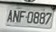

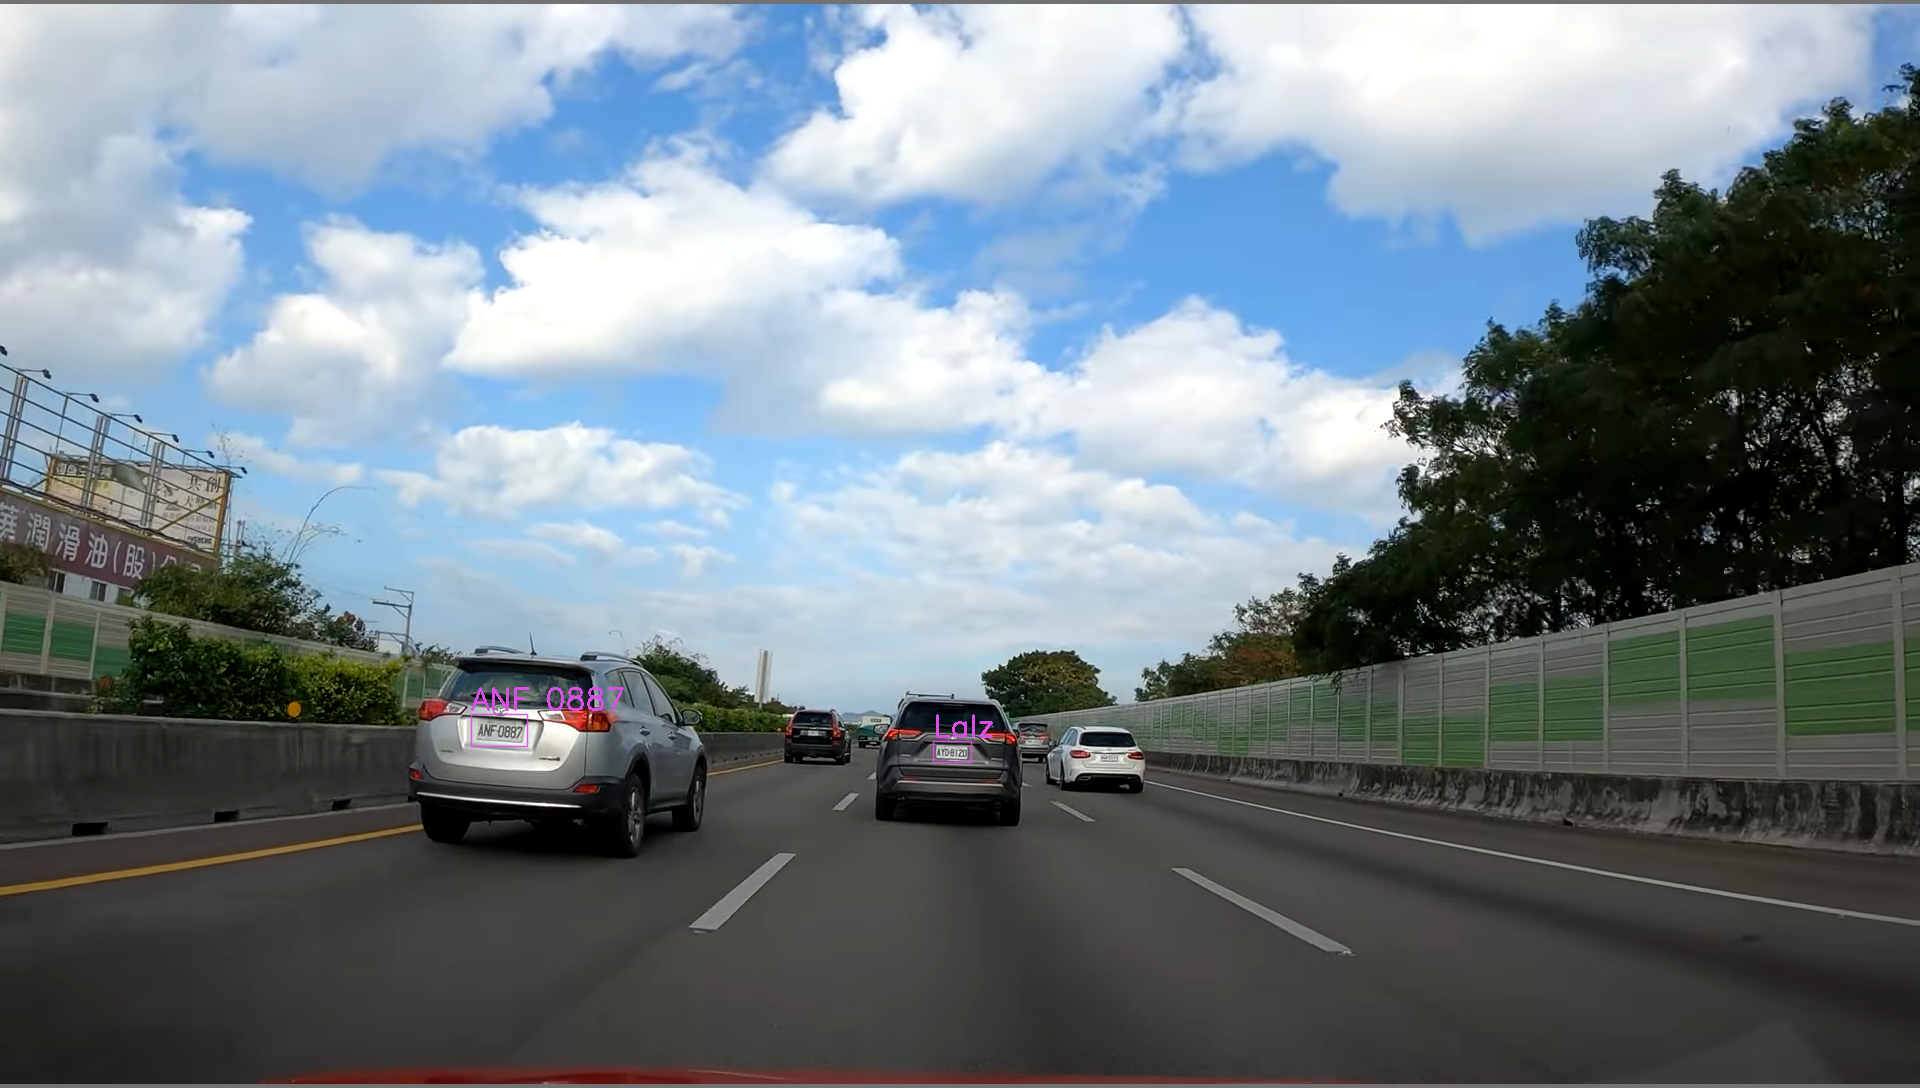

In [12]:
# Number Plate Detection using Yolov7

import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow

from torchvision import transforms
import sys
sys.path.append('/content/drive/MyDrive/yolo7/utils')

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('best.pt')
model = weigths['model']
model = model.half().to(device)
_ = model.eval()

img_path = '/content/drive/MyDrive/yolov7/data/train/54.png'

img = cv2.imread(img_path)

# Get the frame width and height.

h,w,c = img.shape
frame_width = w
frame_height = h


orig_image = img
image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
image = letterbox(image, (frame_width), stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)
image = image.half()

with torch.no_grad():
    output, _ = model(image)

output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], kpt_label=True)
output = output_to_keypoint(output)
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
for idx in range(output.shape[0]):
    # plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

    # Comment/Uncomment the following lines to show bounding boxes around persons.
    xmin, ymin = (output[idx, 2]-output[idx, 4]/2), (output[idx, 3]-output[idx, 5]/2)
    xmax, ymax = (output[idx, 2]+output[idx, 4]/2), (output[idx, 3]+output[idx, 5]/2)

    plate_roi = nimg[int(ymin):int(ymax),int(xmin):int(xmax)]
    #IMG = cv2.imread("Plate.jpg")
    #cv2_imshow(IMG)
    #cv2_imshow("Plate",plate_roi)
    cv2_imshow(plate_roi)
  
    '''
    reader = easyocr.Reader(['en'])
    result = reader.readtext('/content/ANPRwithPython/5.png',paragraph="False")
    result[2][1]
    '''
    reader = easyocr.Reader(['en'])
    result = reader.readtext(plate_roi,paragraph="False")
    result_text=''
    if (len(result)>0):
      result_text=result[0][1]

    cv2.putText(nimg, result_text , (int(xmin), int(ymin)-5), cv2.FONT_HERSHEY_SIMPLEX,1, (228, 79, 215), 2)
    cv2.rectangle(
        nimg,
        (int(xmin), int(ymin)),
        (int(xmax), int(ymax)),
        color=(228, 79, 215),
        thickness=1,
        lineType=cv2.LINE_AA
    )

# Convert from BGR to RGB color format.
cv2.imwrite('result.jpg',nimg)
cv2_imshow(nimg)

In [ ]:
# Number Plate Detection using Yolov7

import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow

from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('best.pt')
model = weigths['model']
model = model.half().to(device)
_ = model.eval()

video_path = '2.mp4'

cap = cv2.VideoCapture(video_path)
if (cap.isOpened() == False):
  print('Error while trying to read video. Please check path again')

# Get the frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Pass the first frame through `letterbox` function to get the resized image,
# to be used for `VideoWriter` dimensions. Resize by larger side.
vid_write_image = letterbox(cap.read()[1], (frame_width), stride=64, auto=True)[0]
resize_height, resize_width = vid_write_image.shape[:2]

# Define codec and create VideoWriter object .
out = cv2.VideoWriter("result.mp4",
                    cv2.VideoWriter_fourcc(*'mp4v'), 30,
                    (resize_width, resize_height))


frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.


while(cap.isOpened):
  # Capture each frame of the video.
  ret, frame = cap.read()
  if ret:
      orig_image = frame
      image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
      image = letterbox(image, (frame_width), stride=64, auto=True)[0]
      image_ = image.copy()
      image = transforms.ToTensor()(image)
      image = torch.tensor(np.array([image.numpy()]))
      image = image.to(device)
      image = image.half()

      # Get the start time.
      start_time = time.time()
      with torch.no_grad():
          output, _ = model(image)
        # Get the end time.
      end_time = time.time()
      # Get the fps.
      fps = 1 / (end_time - start_time)
      # Add fps to total fps.
      total_fps += fps
      # Increment frame count.
      frame_count += 1

      output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], kpt_label=True)
      output = output_to_keypoint(output)
      nimg = image[0].permute(1, 2, 0) * 255
      nimg = nimg.cpu().numpy().astype(np.uint8)
      nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
      for idx in range(output.shape[0]):
          # plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

          # Comment/Uncomment the following lines to show bounding boxes around persons.
          xmin, ymin = (output[idx, 2]-output[idx, 4]/2), (output[idx, 3]-output[idx, 5]/2)
          xmax, ymax = (output[idx, 2]+output[idx, 4]/2), (output[idx, 3]+output[idx, 5]/2)

          plate_roi = nimg[int(ymin):int(ymax),int(xmin):int(xmax)]
          cv2_imshow(plate_roi)
         
          cv2.putText(nimg, "Number Plate", (int(xmin), int(ymin)-5), cv2.FONT_HERSHEY_SIMPLEX,1, (228, 79, 215), 2)
          cv2.rectangle(
              nimg,
              (int(xmin), int(ymin)),
              (int(xmax), int(ymax)),
              color=(228, 79, 215),
              thickness=1,
              lineType=cv2.LINE_AA
          )

      # Write the FPS on the current frame.
      cv2.putText(nimg, f"{fps:.3f} FPS", (15, 30), cv2.FONT_HERSHEY_SIMPLEX,
                  1, (0, 255, 0), 2)
      # Convert from BGR to RGB color format.
      cv2_imshow(nimg)
      out.write(nimg)
      print(f"{fps:.3f} FPS")
      # Press `q` to exit.
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break
  else:
      break
# Release VideoCapture().
cap.release()
# Close all frames and video windows.
cv2.destroyAllWindows()
# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

ModuleNotFoundError: ignored